In [4]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [5]:
train_df = pd.read_csv("train_data_extracted.csv")

In [6]:
test_df = pd.read_csv("test_data_extracted.csv")

### Data Exploration

In [7]:
test_df.head()

,datasheet_link,target_col,text
0,https://lumenart.com/images/alume/awl-01_specs...,lighting,LumenArt LIGHTING SOLUTIONS AWL.01 AWL.01 4 in...
1,https://lumenart.com/images/fabric/rdc/rdc_spe...,lighting,RDC Series LumenArt LIGHTING SOLUTIONS SPECIFI...
2,https://lumenart.com/images/fabric/cyp/cyp_spe...,lighting,LumenArt CYP Series LIGHTING SOLUTIONS CYP8x24...
3,https://lumenart.com/images/designer/wlp_specs...,lighting,"WLP LumenArt LIGHTING SOLUTIONS 0 * 44.9"" SPEC..."
4,https://lumenart.com/images/designer/wcp/wcp-s...,lighting,LumenArt WCP-S LIGHTING SOLUTIONS - Oak Walnut...


In [8]:
total_rows = train_df.shape[0]
print(f"Total number of rows in train_df : {total_rows}")

total_rows = test_df.shape[0]
print(f"Total number of rows in test_df : {total_rows}")

Total number of rows: 400


In [9]:
missing_values_count = train_df.isnull().sum()
print(f"Total number of missing values in train_df{missing_values_count}")

missing_values_count = test_df.isnull().sum()
print(f"Total number of missing values in test_df{missing_values_count}")

datasheet_link      0
target_col          0
text              181
dtype: int64


In [11]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [ ]:
target_counts = train_df['target_col'].value_counts()

# Print the counts
print("Count of each target variable in 'target_col' of Train Dataset:")
print(target_counts)

# Plot the counts as a bar graph
plt.figure(figsize=(10, 6))
target_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Each Target Variable')
plt.xlabel('Target Variables')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Count of each target variable in 'target_col':
target_col
lighting    81
cable       66
fuses       49
others      23
Name: count, dtype: int64


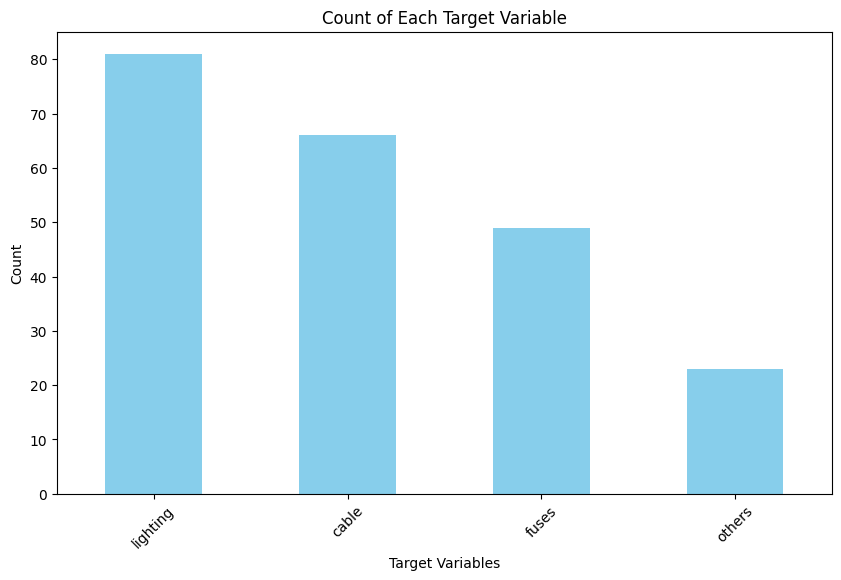

In [12]:
target_counts = test_df['target_col'].value_counts()

# Print the counts
print("Count of each target variable in 'target_col' of Test Dataset:")
print(target_counts)

# Plot the counts as a bar graph
plt.figure(figsize=(10, 6))
target_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Each Target Variable')
plt.xlabel('Target Variables')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Text Preprocessing

In [51]:
def preprocess_text(text):
    # Converting text to lowercase
    text = text.lower()
    
    # Removing special characters, punctuation, and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', '', text)
    
    # Joining single characters that are next to each other with spaces
    text = re.sub(r'(?<=\b\w)(\s+\w\b)+', lambda match: match.group(0).replace(" ", ""), text)
    
    # Tokenizing the text
    words = word_tokenize(text)
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Removing short words (e.g., single-character words) that weren't joined
    words = [word for word in words if len(word) > 2]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return words


In [52]:
train_df['processed_text'] = train_df['text'].apply(lambda x: preprocess_text(x))
test_df['processed_text'] = test_df['text'].apply(lambda x: preprocess_text(x))


In [53]:
test_df["processed_text"]

0      [lumenart, lighting, solution, awl, awl, awl, ...
1      [rdc, series, lumenart, lighting, solution, sp...
2      [lumenart, cyp, series, lighting, solution, cy...
3      [wlp, lumenart, lighting, solution, specificat...
4      [lumenart, wcp, lighting, solution, oak, walnu...
                             ...                        
393    [belden, product, ohm, wireless, transmission,...
395    [belden, product, controlbus, coax, sol, fpe, ...
397    [time, microwave, system, lmr, ultraflex, comm...
398    [belden, product, ohm, sdi, coax, awg, solid, ...
399    [belden, product, ohm, analog, video, coax, aw...
Name: processed_text, Length: 219, dtype: object

### Word2Vec Embedding of preprocessed Text

In [54]:
from gensim.models import Word2Vec

# Create Word2Vec model (using lemmatized text as an example)
model = Word2Vec(sentences=train_df['processed_text'], vector_size=100, window=5, min_count=1, workers=4)

# Convert each text to its Word2Vec representation
# Convert testing text to Word2Vec vectors
train_df['text_vectors'] = train_df['processed_text'].apply(lambda x: [model.wv[word] for word in x if word in model.wv])
test_df['text_vectors'] = test_df['processed_text'].apply(lambda x: [model.wv[word] for word in x if word in model.wv])


### Label Encoding of target variable

In [55]:
from sklearn.preprocessing import LabelEncoder

In [56]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels in 'target_col'
train_df['encoded_target'] = label_encoder.fit_transform(train_df['target_col'])
test_df['encoded_target'] = label_encoder.fit_transform(test_df['target_col'])


In [57]:
# Get the mapping of labels to encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)


{'cable': 0, 'fuses': 1, 'lighting': 2, 'others': 3}


## Model Training

### 1) SVM Classifier

In [58]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, classification_report, accuracy_score
import numpy as np

In [59]:
def pad_vectors(vectors, max_len=100):
    if len(vectors) > max_len:
        vectors = vectors[:max_len]
    else:
        vectors += [np.zeros(vectors[0].shape)] * (max_len - len(vectors))
    return np.array(vectors)

# Defining the flatten function
def flatten_vectors(vectors, max_len=100):
    padded_vectors = pad_vectors(vectors, max_len)
    return padded_vectors.reshape(-1)

# Applying padding and flattening
max_len = 100  # Adjust this value as needed
train_df['processed_text_vectors'] = train_df['text_vectors'].apply(lambda x: flatten_vectors(x, max_len))
test_df['processed_text_vectors'] = test_df['text_vectors'].apply(lambda x: flatten_vectors(x, max_len))

In [60]:
# Converting padded vectors to numpy array
X_train = np.array(list(train_df['processed_text_vectors']))
X_test =  np.array(list(test_df['processed_text_vectors']))
y_train = train_df['encoded_target'].values
y_test =  test_df['encoded_target'].values

In [61]:
# Initializing SVM classifier
svm_model = SVC(kernel='linear')  # You can choose other kernels like 'rbf', 'poly', etc.

# Training the model
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [62]:
# Making predictions and evaluating
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

### Classification Report

In [23]:
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        66
           1       0.94      1.00      0.97        49
           2       0.99      0.99      0.99        81
           3       0.90      0.83      0.86        23

    accuracy                           0.96       219
   macro avg       0.95      0.94      0.95       219
weighted avg       0.96      0.96      0.96       219



In [64]:
import joblib

# Save the pipeline (includes both the vectorizer and the SVM model)
joblib.dump('svm_model.pkl')

print("Model saved as svm_model.pkl")

TypeError: dump() missing 1 required positional argument: 'filename'

### 2) Distil BERT

In [1]:
# Fitting the model
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


In [27]:
# Loading the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [28]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Preprocessing and tokenizing text using DistilBERT tokenizer.

    Parameters:

    - text (str): The input text to be tokenized.

    Returns:
    
    - encoding (dict): Contains tokenized input IDs and attention masks.


In [29]:
def preprocess_text(text):

    encoding = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
    return encoding

# Process training data
train_encodings = [preprocess_text(text) for text in train_df['text']]

# Extract tensors from encodings
input_ids_list = [enc['input_ids'].squeeze(0) for enc in train_encodings]
attention_mask_list = [enc['attention_mask'].squeeze(0) for enc in train_encodings]

# Convert to tensors
train_input_ids = torch.stack(input_ids_list)
train_attention_mask = torch.stack(attention_mask_list)
train_labels = torch.tensor(train_df['encoded_target'].values)

print(f"train_input_ids shape: {train_input_ids.shape}")
print(f"train_attention_mask shape: {train_attention_mask.shape}")
print(f"train_labels shape: {train_labels.shape}")

# Ensure sizes match
assert train_input_ids.shape[0] == train_attention_mask.shape[0] == len(train_labels), "Size mismatch between tensors"

# Create TensorDataset for training
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)

# Create DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

train_input_ids shape: torch.Size([681, 128])
train_attention_mask shape: torch.Size([681, 128])
train_labels shape: torch.Size([681])


In [30]:
print(f"Number of texts in train_df: {len(train_df)}")
print(f"Number of processed encodings: {len(train_encodings)}")
print(f"Number of labels: {len(train_labels)}")

Number of texts in train_df: 681
Number of processed encodings: 681
Number of labels: 681


In [31]:
train_labels = torch.tensor(train_df['encoded_target'].values, dtype=torch.long)

### Training Model 

In [33]:
from tqdm.auto import tqdm
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score
import torch

epoch_losses = []
epoch_accuracies = []


optimizer = AdamW(model.parameters(), lr=5e-5)

scaler = GradScaler()


model.train()
for epoch in range(5): 
    total_loss = 0
    all_labels = []
    all_preds = []
    
    # Ensure tqdm is correctly displaying progress
    pbar = tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}', unit='batch')
    
    for batch in train_loader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        
    
        labels = labels.long()
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        

        scaler.step(optimizer)
        scaler.update()
        
        optimizer.zero_grad(set_to_none=True)
        
        total_loss += loss.item()
        

        with torch.no_grad():
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
        
        pbar.update(1)  
    
    pbar.close()
    
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    
    # Calculate accuracy
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    accuracy = accuracy_score(all_labels, all_preds)
    epoch_accuracies.append(accuracy)
    
    print(f'Epoch {epoch+1} completed with average loss: {avg_loss:.4f} and accuracy: {accuracy:.4f}')

c:\Users\shrit\anaconda3\envs\mlenv\Lib\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1:   0%|          | 0/43 [00:00<?, ?batch/s]

c:\Users\shrit\anaconda3\envs\mlenv\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1 completed with average loss: 0.0122 and accuracy: 0.9985


Epoch 2:   0%|          | 0/43 [00:00<?, ?batch/s]

c:\Users\shrit\anaconda3\envs\mlenv\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 2 completed with average loss: 0.0190 and accuracy: 0.9956


Epoch 3:   0%|          | 0/43 [00:00<?, ?batch/s]

c:\Users\shrit\anaconda3\envs\mlenv\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 3 completed with average loss: 0.0415 and accuracy: 0.9883


Epoch 4:   0%|          | 0/43 [00:00<?, ?batch/s]

c:\Users\shrit\anaconda3\envs\mlenv\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 4 completed with average loss: 0.0124 and accuracy: 0.9985


Epoch 5:   0%|          | 0/43 [00:00<?, ?batch/s]

c:\Users\shrit\anaconda3\envs\mlenv\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 5 completed with average loss: 0.0010 and accuracy: 1.0000


In [36]:
# Processing test data
test_encodings = [preprocess_text(text) for text in test_df['text']]
input_ids_list = [enc['input_ids'].squeeze(0) for enc in test_encodings]
attention_mask_list = [enc['attention_mask'].squeeze(0) for enc in test_encodings]

# Converting to tensors
test_input_ids = torch.stack(input_ids_list)
test_attention_mask = torch.stack(attention_mask_list)

test_dataset = TensorDataset(test_input_ids, test_attention_mask)
test_loader = DataLoader(test_dataset, batch_size=16)

# Making predictions
model.eval()
test_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = [item.to(device) for item in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)

# Add predictions to test_df
test_df['predictions'] = test_preds


### Classification Report

In [37]:
# Assuming you have ground truth labels in test_df['true_labels']
accuracy = accuracy_score(test_df['encoded_target'], test_df['predictions'])
print(f'Test Accuracy: {accuracy:.2f}')
print(classification_report(test_df['encoded_target'], test_df['predictions']))


Test Accuracy: 0.99
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        49
           2       0.99      0.99      0.99        81
           3       0.96      0.96      0.96        23

    accuracy                           0.99       219
   macro avg       0.99      0.99      0.99       219
weighted avg       0.99      0.99      0.99       219



In [38]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Save the model and tokenizer
model_save_path = "./distilbert_model"
tokenizer_save_path = "./distilbert_tokenizer"

# Save the model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!
